In [1]:
# fundamentals
import os, glob
import numpy as np
import pandas as pd
from calendar import monthrange, month_name
import scipy.stats as stats
import funcs as funcs
import datetime
import imp

# plotting libraries and setup
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
%matplotlib inline
fs = 12
plt.rc('font', family='serif')
plt.rc('font', size=fs)
plt.rc('facecolor', )

# met mast functions and utilities
import met_funcs as MET
import vis as vis
import utils as utils

In [2]:
# paths (must mount volume smb://nrel.gov/shared/wind/WindWeb/MetData/135mData/)
towerID = 'M4'
metPathLoHz = '/Volumes/135mData/{}Twr/10min/txt_corrected/'.format(towerID)
figPath = '../../figs/{}'.format(towerID)

In [3]:
# time range
years  = [ int(a) for a in np.arange(2012,2017,1) ] #
months = [ int(a) for a in np.arange(1,12.1,1) ]
# or just get all?


In [4]:
inputfiles = [] # list of files to be read into metdata object
filecount = 0

for year in years:
    for month in months:
        fName = glob.glob(os.path.join(metPathLoHz,'{0}_{1}.txt'.format(year,month_name[month])))        
        if len(fName)>0:
            fName = fName[0] 
            inputfiles.append(fName)
print('{} files to be read into MetData'.format(len(inputfiles)))


50 files to be read into MetData


In [5]:
## load data from list of input data files
metdat = MET.load_met_data(inputfiles,verbose=False)

## use qc columns to mask data (qc != 1 --> questionable data)
metdat = MET.qc_mask(metdat)

## remove columns that are all nans
metdat = MET.drop_nan_cols(metdat)

## flag data by stability class
stabconds, stabcat = MET.flag_stability(metdat)

## group columns based on category, assign units, labels, savenames
varcats, varunits, varlabels, varsave = MET.categorize_fields(metdat, keeplist=True)
catinfo = {}
catinfo['columns'] = varcats
catinfo['units'] = varunits
catinfo['labels'] = varlabels
catinfo['save'] = varsave

# ## drop columns not in any of the categories, filter TI, temperature, stability parameters
MET.groom_data(metdat, varcats)


filtcols = [col for col in metdat.columns if 'air' not in col.lower() and 'humidity' not in col.lower()]
## Finally, reject outliers more than 5 standard deviations from the mean
for col in filtcols:
    try:
        metdat[col] = MET.reject_outliers(metdat[col], m=6)
    except:
        continue

number of data columns: 437
number of QC columns: 443
number of columns after filtering: 127


In [6]:
# M4 excluded angles,
# GE			15		53
# Alstom		12		64
# CART-3		13		54
# CART-2		17		66
# Siemens		55		135
# Gamesa		188		267
exclude_angles = [(15,53),(12,64),(13,54),(17,66),(55,135),(188,267)]

In [7]:
categories = list(catinfo['columns'].keys())

for cat in categories:
    if 'stability flag' in cat.lower():
        continue
    
    # savepath for new figs
    savecat = catinfo['save'][cat]
    catfigpath = os.makedirs(os.path.join(figPath,savecat), mode=0o777, exist_ok=True)
    catfigpath = os.path.join(figPath,savecat)
    
    # Profiles
    ## cumulative profile
    fig, ax = vis.cumulative_profile(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_profile.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## monthly profile
    fig, ax = vis.monthly_profile(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_profile_monthly.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## stability profile
    fig,ax = vis.stability_profile(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_profile_stability.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## monthly stability profile
    fig,ax = vis.monthly_stability_profiles(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_profile_monthly_stability.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    # Diurnal cycle
    ## cumulative hourly plot
    fig,ax = vis.hourlyplot(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_hourly.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## monthly hourly plot
    fig,ax = vis.monthlyhourlyplot(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_hourly_monthly.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')

    plt.close('all')
    
    

## Figures by height
Each of the following figures could be drawn for any probe height. Currently, figures are only drawn for z=80m (hub height)

In [15]:
categories = list(catinfo['columns'].keys())

for cat in categories:
    if 'stability flag' in cat.lower():
        continue
    
    # savepath for new figs
    savecat = catinfo['save'][cat]
    catfigpath = os.path.join(figPath,savecat)
    
    catcolumns, probe_heights, _ = utils.get_vertical_locations(catinfo['columns'][cat])
    
    ## wind roses by height
    for height in [80]:#probe_heights:
    
        # SCATTER PLOTS
        ## cumulative scatter
        fig, ax = vis.winddir_scatter(metdat, catinfo, cat, vertloc=height, exclude_angles=exclude_angles)
        fig.savefig(os.path.join(catfigpath,'{}_{}_scatter_{}.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')

        # stability scatter
        fig, ax = vis.stability_winddir_scatter(metdat, catinfo, cat, vertloc=height)
        fig.savefig(os.path.join(catfigpath,'{}_{}_scatter_stability_{}.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')

        # HISTOGRAMS
        # cumulative
        fig,ax = vis.hist(metdat, catinfo, cat, vertloc=height)
        fig.savefig(os.path.join(catfigpath,'{}_{}_hist_{}.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')

        # stability breakout
        fig,ax = vis.hist_by_stability(metdat, catinfo, cat, vertloc=height)
        fig.savefig(os.path.join(catfigpath,'{}_{}_hist_stabilty_{}.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')

        # stability stacked
        fig,ax = fig,ax = vis.stacked_hist_by_stability(metdat, catinfo, cat, vertloc=height)
        fig.savefig(os.path.join(catfigpath,'{}_{}_hist_stabilty_stacked_{}.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')
        
        if 'ti' not in cat.lower():
            # groupby direction scatter
            fig,ax = vis.groupby_scatter(metdat, catinfo, cat, vertloc=height, abscissa='direction', groupby='ti')
            fig.set_size_inches(8,3)
            fig.tight_layout()
            fig.savefig(os.path.join(catfigpath,'{}_{}_TI_scatter_{}m.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')

    plt.close('all')

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/nhamilto/anaconda/lib/python3.6/site-packages/pandas/plotting/_core.py:1060: RuntimeWarning: invalid value encountered in greater_equal
  if (values >= 0).all():
/Users/nhamilto/anaconda/lib/python3.6/site-packages/pandas/plotting/_core.py:1062: RuntimeWarning: invalid value encountered in less_equal
  elif (values <= 0).all():


## Wind roses
Might as well draw all of the wind roses (by height)

In [16]:
# wind roses
cat = 'speed'
catcolumns, probe_heights, ind = utils.get_vertical_locations(catinfo['columns'][cat])
# savepath for new figs
savecat = catinfo['save'][cat]
catfigpath = os.makedirs(os.path.join(figPath,savecat,'roses'), mode=0o777, exist_ok=True)
catfigpath = os.path.join(figPath,savecat,'roses')
## wind roses by height
for height in probe_heights:
    ## cumulative wind rose
    fig,ax,leg = vis.rose_fig(metdat, catinfo, cat, vertloc=height, bins=np.linspace(0,15,6), ylim=9)
    fig.savefig(os.path.join(catfigpath,'{}_{}_rose_{}m.png'.format(towerID, cat, height)), dpi=200, bbox_inches='tight')
    ## monthly wind roses
    fig,ax,leg = vis.monthly_rose_fig(metdat, catinfo, cat, vertloc=height, bins=np.linspace(0,15,6), ylim=12)
    fig.savefig(os.path.join(catfigpath,'{}_{}_rose_monthly_{}m.png'.format(towerID, cat, height)), dpi=200, bbox_inches='tight')

    plt.close('all')

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


In [10]:
# TI roses
cat = 'ti'
catcolumns, probe_heights, ind = utils.get_vertical_locations(catinfo['columns'][cat])
# savepath for new figs
savecat = catinfo['save'][cat]
catfigpath = os.makedirs(os.path.join(figPath,savecat,'roses'), mode=0o777, exist_ok=True)
catfigpath = os.path.join(figPath,savecat,'roses')
## wind roses by height
for height in probe_heights:
    ## cumulative wind rose
    fig,ax,leg = vis.rose_fig(metdat, catinfo, cat, vertloc=height, bins=np.linspace(0,40,6), ylim=12)
    fig.savefig(os.path.join(catfigpath,'{}_{}_rose_{}m.png'.format(towerID, cat, height)), dpi=200, bbox_inches='tight')
    ## monthly wind roses
    fig,ax,leg = vis.monthly_rose_fig(metdat, catinfo, cat, vertloc=height, bins=np.linspace(0,40,6), ylim=14)
    fig.savefig(os.path.join(catfigpath,'{}_{}_rose_monthly_{}m.png'.format(towerID, cat, height)), dpi=200, bbox_inches='tight')

    plt.close('all')

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


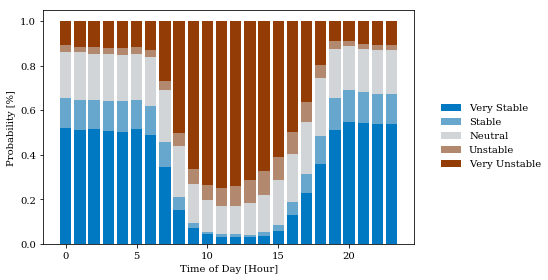

In [11]:
fig, ax = vis.normalized_hist_by_stability(metdat, catinfo)
fig.savefig(os.path.join(figPath,'{}_normalized_stability_flag.png'.format(towerID)), dpi=200, bbox_inches='tight')

/Volumes/Sitechar/coderepo/nicholas/vis.py:847: PerformanceWarning: indexing past lexsort depth may impact performance.
  pdat = temp.loc[ii+1,cond]


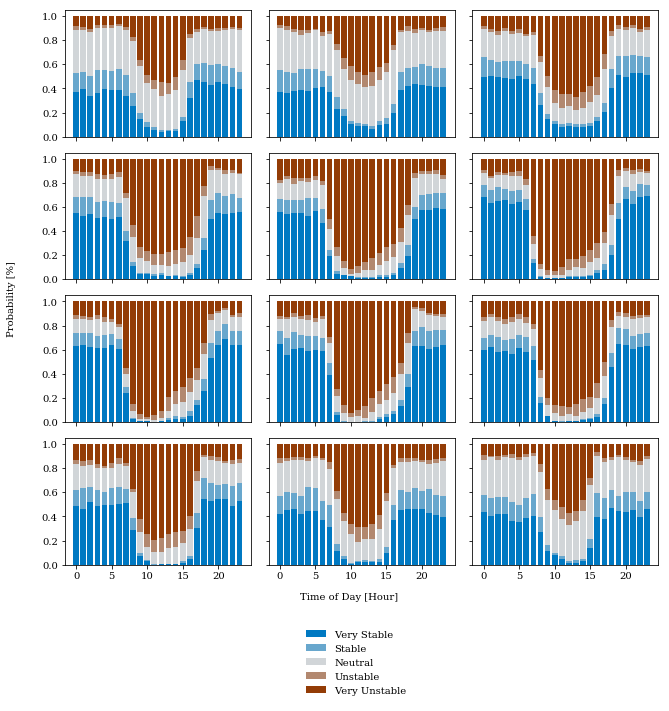

In [12]:
fig, ax = vis.normalized_monthly_hist_by_stability(metdat,catinfo)
fig.savefig(os.path.join(figPath,'{}_normalized_stability_flag_monthly.png'.format(towerID)), dpi=200, bbox_inches='tight')